## Sequential PC-Kriging Implementation


### Motivating Example

We consider the function $$ y=-cos(\pi x) + sin(\pi x) + \epsilon$$  where  $$x \in [0,10] \quad \epsilon \sim N(0,0.4) $$ This function will be used to generate synthetic data for building and testing our Sequential PC-Kriging model.

In [273]:
import numpy as np
import chaospy as cp
import GPy

class SequentialPCKriging:
    def __init__(self, input_dist, order=3):
        self.input_dist = input_dist
        self.expansion = cp.generate_expansion(order, input_dist)
        self.gp_model = None

    def fit_pce(self, x, y):
        if x.ndim == 2 and x.shape[1] == 1:
            x = x.flatten()
        if y.ndim == 2 and y.shape[1] == 1:
            y = y.flatten()
        self.pce_model = cp.fit_regression(self.expansion, x, y)

    def fit_kriging(self, x, y):
        discrepancy = y - self.pce_model(x)
        kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
        self.gp_model = GPy.models.GPRegression(x, discrepancy, kernel)
        self.gp_model.optimize()

    def predict(self, x_new):
        pce_pred = self.pce_model(x_new)
        gp_pred, gp_var = self.gp_model.predict(x_new)
        return pce_pred + gp_pred, np.sqrt(gp_var)

In [274]:
# Data Generation
np.random.seed(1234)
n = 30
X = np.random.rand(n, 1) * 10  # Training inputs, n x 1 vector
# Use linspace for X instead but preserve the dimension of X
X = np.linspace(0, 10, n).reshape(-1, 1)
sigma = 0.4  # Noise standard deviation

# Defining the true function with normal noise included
def f_true(x):
    noise = np.random.normal(0, sigma, x.shape)
    return -np.cos(np.pi * x) + np.sin(4. * np.pi * x) + noise

Y = f_true(X)  # Training outputs

# ======== everything above is in a black-box, we only know X, Y ========


In [275]:
input_dist = cp.Uniform(0, 10)

# Initialize the SequentialPCKriging model
model = SequentialPCKriging(input_dist, order=5)

# Fit PCE and Kriging models
model.fit_pce(X, Y)
model.fit_kriging(X, Y)

# Making predictions
x_test = np.linspace(0, 10, 100).reshape(-1, 1)
y_pred, y_std = model.predict(x_test)

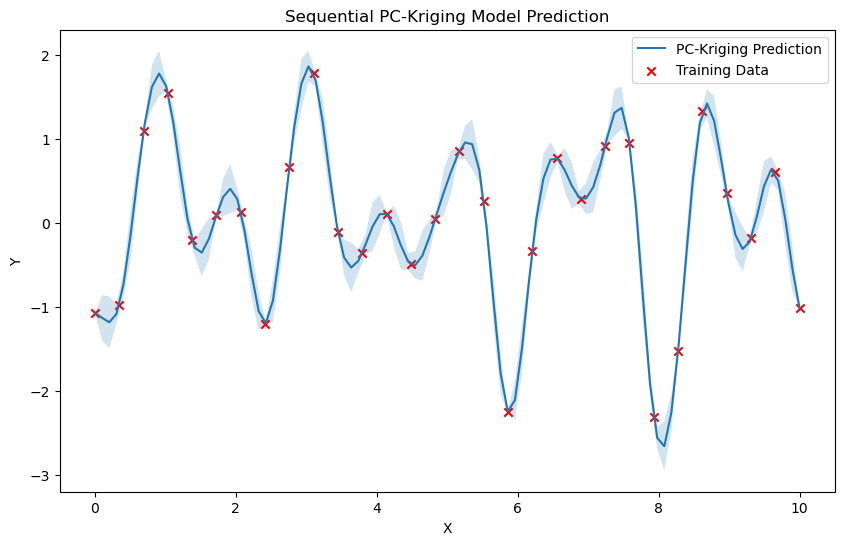

In [276]:
# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(x_test, y_pred, label='PC-Kriging Prediction')
plt.fill_between(x_test.flatten(), (y_pred - y_std).flatten(), (y_pred + y_std).flatten(), alpha=0.2)
plt.scatter(X, Y, marker='x', c='r', label='Training Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Sequential PC-Kriging Model Prediction')
plt.legend()
plt.show()

In [277]:
# Define the kernel
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

# Create the GP model
gp_model = GPy.models.GPRegression(X, Y, kernel)

# Optimize the model (find the best hyperparameters)
gp_model.optimize(messages=True)

# Print the optimized model's parameter values
print(gp_model)


Name : GP regression
Objective : 42.13151295760575
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |     1.2131483686866975  |      +ve      |        
  rbf.lengthscale          |    0.26159402745958643  |      +ve      |        
  Gaussian_noise.variance  |  5.562155021398124e-07  |      +ve      |        


In [278]:
# Define the range of the input
q_pce = cp.Uniform(0, 10)

# Create an orthogonal polynomial basis
degree = 5  # Degree of the polynomial
polynomials_pce = cp.orth_ttr(degree, q_pce)

# Fit the PCE model to the data
pce_model_cp = cp.fit_regression(polynomials_pce, X.flatten(), Y.flatten())

In [279]:
# True function calculation
def f_cal(x):
    return -np.cos(np.pi * x) + np.sin(4. * np.pi * x)

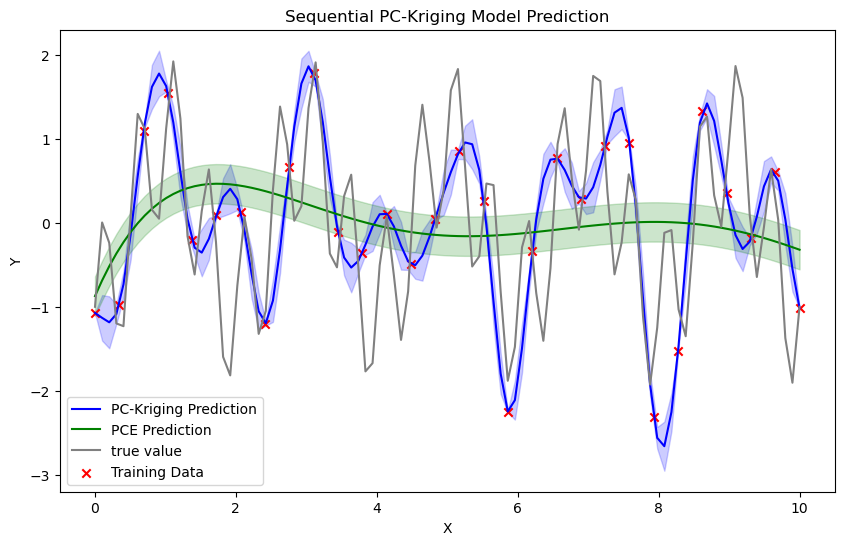

In [280]:
# Predict at new data points with gp
y_pred_gp, y_var_gp = gp_model.predict(x_test)  # Predictive mean and variance
y_std_gp = np.sqrt(y_var_gp)

# Predict at new data points with pce
y_pred_pce = pce_model_cp(x_test)
y_std_pce = np.sqrt(cp.Var(pce_model_cp, q_pce))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_test, y_pred, label='PC-Kriging Prediction', color='blue')
# plt.plot(x_test, y_pred_gp, label='Kriging Prediction', color='orange')
plt.plot(x_test, y_pred_pce, label='PCE Prediction', color='green')
plt.plot(x_test, [f_cal(xi) for xi in x_test], label='true value', color='grey')
# plot pce result
plt.fill_between(x_test.flatten(), (y_pred - y_std).flatten(), (y_pred + y_std).flatten(), alpha=0.2, color='blue')
# plt.fill_between(x_test.flatten(), (y_pred_gp - y_std_gp).flatten(), (y_pred_gp + y_std_gp).flatten(), alpha=0.2, color='orange')
plt.fill_between(x_test.flatten(), (y_pred_pce - y_std_pce).flatten(), (y_pred_pce + y_std_pce).flatten(), alpha=0.2, color='green')
plt.scatter(X, Y, marker='x', c='r', label='Training Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Sequential PC-Kriging Model Prediction')
plt.legend()
plt.show()

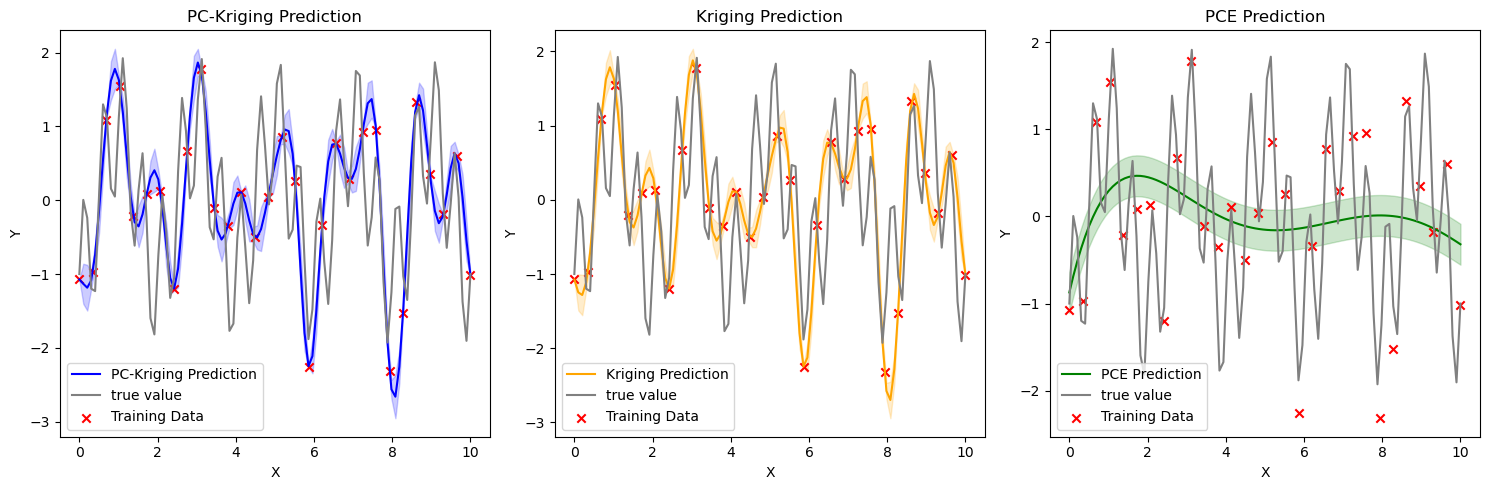

In [281]:
# Set up the figure and subplots
plt.figure(figsize=(15, 5))

# Plot for PC-Kriging
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
plt.plot(x_test, y_pred, label='PC-Kriging Prediction', color='blue')
plt.plot(x_test, [f_cal(xi) for xi in x_test], label='true value', color='grey')
plt.fill_between(x_test.flatten(), (y_pred - y_std).flatten(), (y_pred + y_std).flatten(), alpha=0.2, color='blue')
plt.scatter(X, Y, marker='x', c='r', label='Training Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('PC-Kriging Prediction')
plt.legend()

# Plot for Kriging
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
plt.plot(x_test, y_pred_gp, label='Kriging Prediction', color='orange')
plt.plot(x_test, [f_cal(xi) for xi in x_test], label='true value', color='grey')
plt.fill_between(x_test.flatten(), (y_pred_gp - y_std_gp).flatten(), (y_pred_gp + y_std_gp).flatten(), alpha=0.2, color='orange')
plt.scatter(X, Y, marker='x', c='r', label='Training Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Kriging Prediction')
plt.legend()

# Plot for PCE
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
plt.plot(x_test, y_pred_pce, label='PCE Prediction', color='green')
plt.plot(x_test, [f_cal(xi) for xi in x_test], label='true value', color='grey')
plt.fill_between(x_test.flatten(), (y_pred_pce - y_std_pce).flatten(), (y_pred_pce + y_std_pce).flatten(), alpha=0.2, color='green')
plt.scatter(X, Y, marker='x', c='r', label='Training Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('PCE Prediction')
plt.legend()

plt.tight_layout()
plt.show()